In [ ]:
!pip install pulp

In [ ]:
import pulp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 3. Định nghĩa tham số đầu vào
P_max       = 500000                 # Wh, dung lượng tối đa pin
SoC_down    = 10                     # %, ngưỡng SoC thấp nhất
SoC_up      = 95                     # %, ngưỡng SoC cao nhất
P_PCS       = 90                    # %, công suất PCS tối đa so với P_max
eta         = 0.95                   # hiệu suất sạc/xả
P_bat_min   = P_max * SoC_down/100   # Wh, ngưỡng pin tối thiểu (10%)
P_bat_max   = P_max * SoC_up/100     # Wh, ngưỡng pin tối đa (95%)

In [ ]:
import pandas as pd
import numpy as np

# Đọc file CSV
df = pd.read_csv("1 month scheduling june.csv", parse_dates=["Time"])

# Đổi tên cột cho đồng bộ
df.rename(columns={
    "Time": "Hour",
    "pv_generation": "PV (kW)",
    "load_demand": "Load (kW)",
    "grid_price": "TOU Price"
}, inplace=True)

# ==== CHỌN THỜI GIAN ====
start_day = pd.to_datetime("2023-6-01")
end_day = start_day + pd.Timedelta(days=7)

# Lọc dữ liệu theo thời gian
df_week = df[(df["Hour"] >= start_day) & (df["Hour"] <= end_day)]

# ==== Tạo các mảng số ====
P_solar = (df_week["PV (kW)"].to_numpy() * 1000).astype(float)   # W
demand = (df_week["Load (kW)"].to_numpy() * 1000).astype(float) # W
price = df_week["TOU Price"].to_numpy()                         # USD/kWh
hours = range(len(P_solar))

# In kiểm tra
print("Số phần tử:", len(P_solar), len(demand), len(price))
print("Giờ đầu:", df_week["Hour"].iloc[0])
print("Giờ cuối:", df_week["Hour"].iloc[-1])

Số phần tử: 169 169 169
Giờ đầu: 2023-06-01 00:00:00
Giờ cuối: 2023-06-08 00:00:00


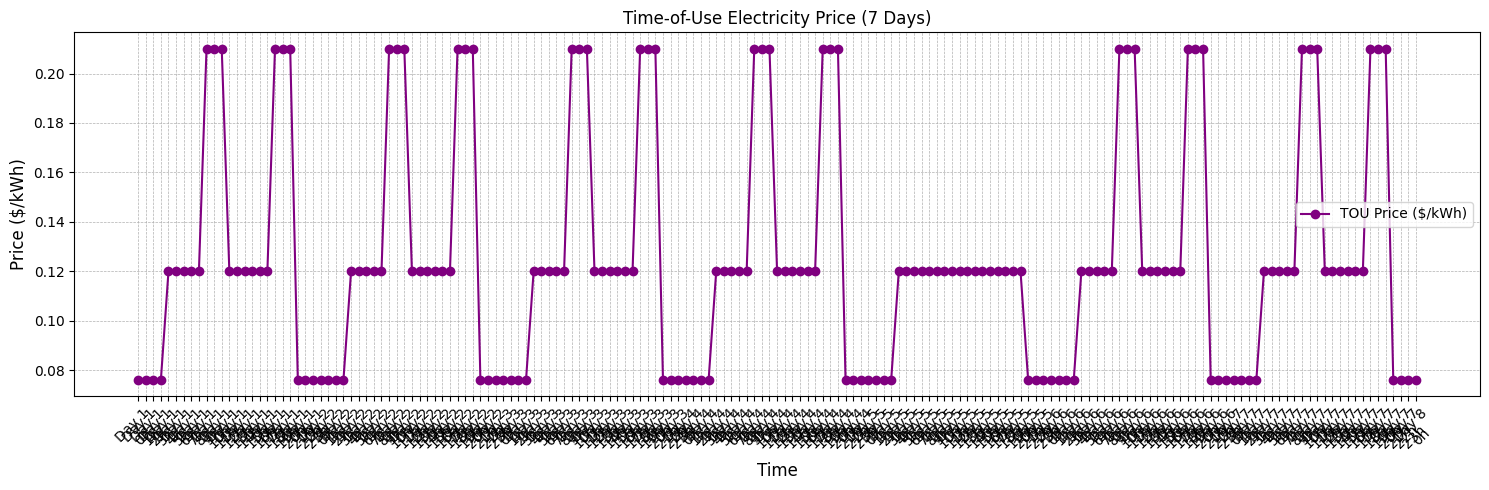

In [ ]:
sample_interval = 1  # Lấy mẫu mỗi giờ

# Danh sách giờ
hours = list(range(len(price)))

# Lấy mẫu dữ liệu
sampled_hours = list(range(0, len(price), sample_interval))
sampled_price = [price[t] for t in sampled_hours]

# Tạo nhãn trục X: Day i \n xxh
sampled_labels = []
for h in sampled_hours:
    day = h // 24 + 1
    hour_in_day = h % 24
    sampled_labels.append(f"Day {day}\n{hour_in_day}h")

# Vẽ biểu đồ
plt.figure(figsize=(15, 5))
plt.plot(sampled_hours, sampled_price, label="TOU Price ($/kWh)", marker='o', linestyle='-', color='purple')

plt.title(f"Time-of-Use Electricity Price ({day - 1} Day{'s' if day > 2 else ''})")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price ($/kWh)", fontsize=12)

plt.xticks(sampled_hours, sampled_labels, rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### **GRID+PV+BESS**

In [ ]:
# 4. Khởi tạo mô hình tối ưu hóa
model = pulp.LpProblem("Microgrid_Cost_Minimization_Day1", pulp.LpMinimize)

In [ ]:
# 5. Khai báo biến quyết định
P_bat         = pulp.LpVariable.dicts("P_bat",          hours, lowBound=P_bat_min, upBound=P_bat_max, cat='Continuous')
P_solar_charge = pulp.LpVariable.dicts("P_solar_charge", hours, lowBound=0,      cat='Continuous')
P_grid_charge  = pulp.LpVariable.dicts("P_grid_charge",  hours, lowBound=0,      cat='Continuous')
P_grid_use_demand    = pulp.LpVariable.dicts("P_grid_use_demand",     hours, lowBound=0,      cat='Continuous')
P_discharge   = pulp.LpVariable.dicts("P_discharge",    hours, lowBound=0,      cat='Continuous')
P_solar_use_demand = pulp.LpVariable.dicts("P_solar_use_demand", hours, lowBound=0, cat="Continuous")


In [ ]:
# # 6. Ràng buộc
# # (25) P_min ≤ P_bat[t] ≤ P_max
for t in hours:
     model += P_bat[t] >= P_bat_min, f"Battery_Min_{t}"
     model += P_bat[t] <= P_bat_max, f"Battery_Max_{t}"
for t in hours:
     if t == 0:
         model += P_bat[0] == P_bat_min, f"Init_Battery_Level_{t}"
     else:
         model += (P_bat[t] == P_bat[t-1] + eta * (P_grid_charge[t-1] + P_solar_charge[t-1]) - P_discharge[t-1] * (1.0/eta)), f"Battery_Update_{t}"

# (26) P_solar_charge[t] ≤ P_PCS * P_max
#for t in hours:
#    model += P_solar_charge[t] <= (P_PCS/100) * P_max, f"PCS_Limit_{t}"
# # (28-29):
for t in hours:
     model += (P_grid_charge[t] + P_solar_charge[t]) <= (P_PCS/100) * P_max, f"Charge_Limit_{t}"
     model += P_discharge[t] <= (P_PCS/100) * P_max, f"Discharge_Limit_{t}"

# (27) P_solar_charge[t] + P_solar_use_demand[t] ≤ P_solar[t]

for t in hours:
     model += (P_solar_use_demand[t] + P_solar_charge[t] <= P_solar[t]), f"PV_Total_Limit_{t}"

# (30) Cân bằng phụ tải:
for t in hours:
    model += (P_grid_use_demand[t] + P_discharge[t] + P_solar_use_demand[t] == demand[t]), f"Load_Balance_{t}"



In [ ]:
# 7. Hàm mục tiêu: Tối thiểu hóa chi phí mua điện từ lưới
# Đổi đơn vị USD/kWh → USD/Wh
price_per_Wh = price / 1000
model += pulp.lpSum([price_per_Wh[t] * (P_grid_use_demand[t] + P_grid_charge[t])
    for t in hours
]), "Total_Grid_Cost"


In [ ]:
# 8. Giải bài toán
model.solve()

1

In [ ]:
# Sau khi model.solve()

status = pulp.LpStatus[model.status]
print("Status:", status)
if status != "Optimal":
    print("Warning: model did not find an optimal solution.")

# Hàm phụ để lấy giá trị, chuyển None → 0
def safe_val(x):
    return x.varValue if x.varValue is not None else 0.0

# In kết quả cho mỗi giờ
for t in hours:
    bat   = safe_val(P_bat[t])
    solCh = safe_val(P_solar_charge[t])
    grdCh = safe_val(P_grid_charge[t])
    dis   = safe_val(P_discharge[t])
    grdUs = safe_val(P_grid_use_demand[t])
    solUs = safe_val(P_solar_use_demand[t])
    dm = demand[t]
    print(f"Hour {t:02d}: Bat={bat:.1f}W | SolarCh={solCh:.1f}W | "
          f"GridCh={grdCh:.1f}W | Disch={dis:.1f}W | GridUse={grdUs:.1f}W |SolarUseDemand={solUs:.1f}W| Demand={dm:.1f}W")


Status: Optimal
Hour 00: Bat=50000.0W | SolarCh=0.0W | GridCh=367047.9W | Disch=0.0W | GridUse=84964.1W |SolarUseDemand=0.0W| Demand=84964.1W
Hour 01: Bat=398695.5W | SolarCh=0.0W | GridCh=0.0W | Disch=0.0W | GridUse=62207.1W |SolarUseDemand=0.0W| Demand=62207.1W
Hour 02: Bat=398695.5W | SolarCh=0.0W | GridCh=0.0W | Disch=0.0W | GridUse=111636.8W |SolarUseDemand=0.0W| Demand=111636.8W
Hour 03: Bat=398695.5W | SolarCh=0.0W | GridCh=0.0W | Disch=0.0W | GridUse=77587.6W |SolarUseDemand=0.0W| Demand=77587.6W
Hour 04: Bat=398695.5W | SolarCh=0.0W | GridCh=0.0W | Disch=78114.9W | GridUse=0.0W |SolarUseDemand=0.0W| Demand=78114.9W
Hour 05: Bat=316469.2W | SolarCh=0.0W | GridCh=0.0W | Disch=79743.7W | GridUse=0.0W |SolarUseDemand=0.0W| Demand=79743.7W
Hour 06: Bat=232528.5W | SolarCh=0.0W | GridCh=0.0W | Disch=68362.1W | GridUse=0.0W |SolarUseDemand=0.0W| Demand=68362.1W
Hour 07: Bat=160568.3W | SolarCh=330980.7W | GridCh=0.0W | Disch=0.0W | GridUse=0.0W |SolarUseDemand=245219.8W| Demand=24521

In [ ]:
# Tính chi phí khi dùng microgrid (đã tối ưu)
cost_microgrid = sum([
    price_per_Wh[t] * (safe_val(P_grid_use_demand[t]) + safe_val(P_grid_charge[t]))
    for t in hours
])
# In kết quả
print(f"Chi phí khi dùng microgrid:        {cost_microgrid:.2f} USD")


Chi phí khi dùng microgrid:        1988.41 USD


### **GRID+PV**

In [ ]:
# 2. PV + NỐI LƯỚI – KHÔNG BESS
model_pv_grid = pulp.LpProblem("PV_Grid_Cost_Minimization", pulp.LpMinimize)

# Biến quyết định: điện mua từ lưới
P_grid_use_pv = pulp.LpVariable.dicts("P_grid_use_pv", hours, lowBound=0, cat='Continuous')

# Ràng buộc: cân bằng tải
for t in hours:
    # PV dùng trực tiếp cho tải, phần còn lại lấy từ lưới
    pv_to_load = min(P_solar[t], demand[t])
    model_pv_grid += P_grid_use_pv[t] + pv_to_load == demand[t], f"Load_Balance_PVGrid_{t}"

# Hàm mục tiêu: tối thiểu hóa chi phí mua điện từ lưới
model_pv_grid += pulp.lpSum([price_per_Wh[t] * P_grid_use_pv[t] for t in hours]), "Total_PV_Grid_Cost"

# Giải bài toán
model_pv_grid.solve()
status = pulp.LpStatus[model_pv_grid.status]
print("Status:", status)
print("\n=== Kết quả: PV + NỐI LƯỚI ===")
for t in hours:
    pv_to_load = min(P_solar[t], demand[t])
    grid = safe_val(P_grid_use_pv[t])
    print(f"Hour {t:02d}: PVtoLoad={pv_to_load:.1f}Wh | GridUse={grid:.1f}Wh")

cost_pv_grid = sum([price_per_Wh[t] * safe_val(P_grid_use_pv[t]) for t in hours])
print(f"→ Tổng chi phí (PV + lưới): {cost_pv_grid:.2f} USD")

Status: Optimal

=== Kết quả: PV + NỐI LƯỚI ===
Hour 00: PVtoLoad=0.0Wh | GridUse=84964.1Wh
Hour 01: PVtoLoad=0.0Wh | GridUse=62207.1Wh
Hour 02: PVtoLoad=0.0Wh | GridUse=111636.8Wh
Hour 03: PVtoLoad=0.0Wh | GridUse=77587.6Wh
Hour 04: PVtoLoad=0.0Wh | GridUse=78114.9Wh
Hour 05: PVtoLoad=0.0Wh | GridUse=79743.7Wh
Hour 06: PVtoLoad=0.0Wh | GridUse=68362.1Wh
Hour 07: PVtoLoad=245219.8Wh | GridUse=0.0Wh
Hour 08: PVtoLoad=329573.5Wh | GridUse=158308.4Wh
Hour 09: PVtoLoad=351589.7Wh | GridUse=185508.1Wh
Hour 10: PVtoLoad=210077.1Wh | GridUse=210556.8Wh
Hour 11: PVtoLoad=416828.2Wh | GridUse=0.0Wh
Hour 12: PVtoLoad=342274.8Wh | GridUse=0.0Wh
Hour 13: PVtoLoad=249547.9Wh | GridUse=115410.3Wh
Hour 14: PVtoLoad=243266.9Wh | GridUse=140006.1Wh
Hour 15: PVtoLoad=365388.0Wh | GridUse=153412.3Wh
Hour 16: PVtoLoad=268465.2Wh | GridUse=255629.9Wh
Hour 17: PVtoLoad=376265.5Wh | GridUse=0.0Wh
Hour 18: PVtoLoad=0.0Wh | GridUse=265351.9Wh
Hour 19: PVtoLoad=0.0Wh | GridUse=129876.3Wh
Hour 20: PVtoLoad=0.0Wh

### **GRID_ONLY**

In [ ]:
# 1. CHỈ NỐI LƯỚI – KHÔNG PV, KHÔNG BESS
model_grid_only = pulp.LpProblem("Grid_Only_Cost_Minimization", pulp.LpMinimize)

# Biến quyết định: chỉ có P_grid_use
P_grid_use_only = pulp.LpVariable.dicts("P_grid_use_only", hours, lowBound=0, cat='Continuous')

# Ràng buộc: phụ tải hoàn toàn đến từ lưới
for t in hours:
    model_grid_only += P_grid_use_only[t] == demand[t], f"Load_Balance_GridOnly_{t}"

# Hàm mục tiêu: tối thiểu hóa chi phí từ lưới
model_grid_only += pulp.lpSum([price_per_Wh[t] * P_grid_use_only[t] for t in hours]), "Total_Grid_Only_Cost"

# Giải bài toán
model_grid_only.solve()

print("\n=== Kết quả: CHỈ NỐI LƯỚI ===")
for t in hours:
    grid = safe_val(P_grid_use_only[t])
    print(f"Hour {t:02d}: GridUse={grid:.1f}Wh")

cost_grid_only = sum([price_per_Wh[t] * safe_val(P_grid_use_only[t]) for t in hours])
print(f"→ Tổng chi phí (chỉ lưới): {cost_grid_only:.2f} USD")


=== Kết quả: CHỈ NỐI LƯỚI ===
Hour 00: GridUse=84964.1Wh
Hour 01: GridUse=62207.1Wh
Hour 02: GridUse=111636.8Wh
Hour 03: GridUse=77587.6Wh
Hour 04: GridUse=78114.9Wh
Hour 05: GridUse=79743.7Wh
Hour 06: GridUse=68362.1Wh
Hour 07: GridUse=245219.8Wh
Hour 08: GridUse=487881.9Wh
Hour 09: GridUse=537097.8Wh
Hour 10: GridUse=420633.9Wh
Hour 11: GridUse=416828.2Wh
Hour 12: GridUse=342274.8Wh
Hour 13: GridUse=364958.2Wh
Hour 14: GridUse=383273.0Wh
Hour 15: GridUse=518800.3Wh
Hour 16: GridUse=524095.1Wh
Hour 17: GridUse=376265.5Wh
Hour 18: GridUse=265351.9Wh
Hour 19: GridUse=129876.3Wh
Hour 20: GridUse=87436.6Wh
Hour 21: GridUse=88280.2Wh
Hour 22: GridUse=104133.0Wh
Hour 23: GridUse=73944.3Wh
Hour 24: GridUse=70463.9Wh
Hour 25: GridUse=72583.9Wh
Hour 26: GridUse=67089.4Wh
Hour 27: GridUse=62752.3Wh
Hour 28: GridUse=76521.7Wh
Hour 29: GridUse=69516.2Wh
Hour 30: GridUse=67678.4Wh
Hour 31: GridUse=124258.6Wh
Hour 32: GridUse=118100.6Wh
Hour 33: GridUse=149374.9Wh
Hour 34: GridUse=127983.6Wh
Hour 

In [ ]:

print(f"→ Tổng chi phí (chỉ lưới): {cost_grid_only:.2f} USD")
print(f"→ Tổng chi phí (PV + lưới): {cost_pv_grid:.2f} USD")
print(f"→ Chi phí khi dùng microgrid: {cost_microgrid:.2f} USD")


→ Tổng chi phí (chỉ lưới): 6052.35 USD
→ Tổng chi phí (PV + lưới): 2757.91 USD
→ Chi phí khi dùng microgrid: 1988.41 USD


### **COMPARE 3 MODELS**

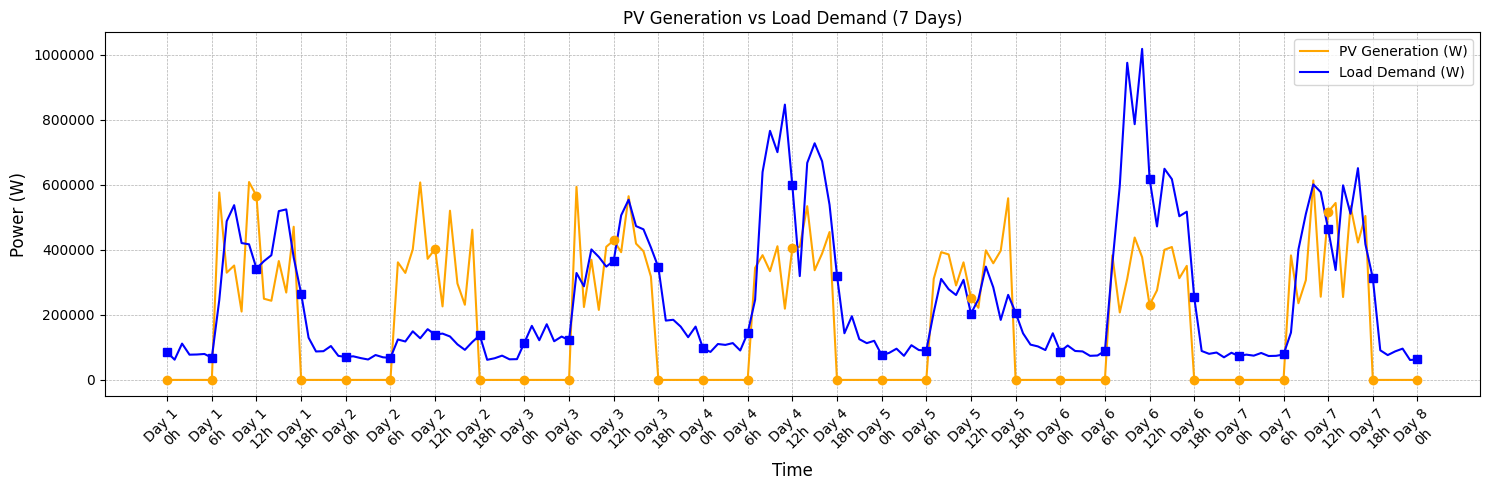

In [ ]:
from matplotlib.ticker import FuncFormatter, MultipleLocator

def format_yaxis(value, _):
    return f'{int(value)}'
sample_interval = 1  # Lấy dữ liệu mỗi 1 giờ
marker_interval = 6  # Marker mỗi 6 giờ

solar_vals = [P_solar[t] for t in hours]
demand_vals = [demand[t] for t in hours]

sampled_hours = list(range(0, len(P_solar), sample_interval))
sampled_solar = [solar_vals[t] for t in sampled_hours]
sampled_demand = [demand_vals[t] for t in sampled_hours]

# Marker mỗi 6 giờ
marker_hours = sampled_hours[::marker_interval]
marker_solar = [solar_vals[t] for t in marker_hours]
marker_demand = [demand[t] for t in marker_hours]

# Nhãn trục X
sampled_labels = []
for h in sampled_hours:
    day = h // 24 + 1
    hour_in_day = h % 24
    sampled_labels.append(f"Day {day}\n{hour_in_day}h")

xtick_interval = 6
xtick_positions = sampled_hours[::xtick_interval]
xtick_labels = [sampled_labels[i] for i in range(0, len(sampled_labels), xtick_interval)]

# Vẽ biểu đồ
plt.figure(figsize=(15, 5))

# Vẽ đường liên tục không marker
plt.plot(sampled_hours, sampled_solar, label="PV Generation (W)", linestyle='-', color='orange')
plt.plot(sampled_hours, sampled_demand, label="Load Demand (W)", linestyle='-', color='blue')

# Vẽ marker tại mỗi 6 giờ
plt.plot(marker_hours, marker_solar, 'o', color='orange')
plt.plot(marker_hours, marker_demand, 's', color='blue')

plt.title(f"PV Generation vs Load Demand ({day-1} Day{'s' if day > 2 else ''})")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (W)", fontsize=12)
plt.xticks(xtick_positions, xtick_labels, rotation=45)
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))
plt.legend()
plt.tight_layout()
plt.show()


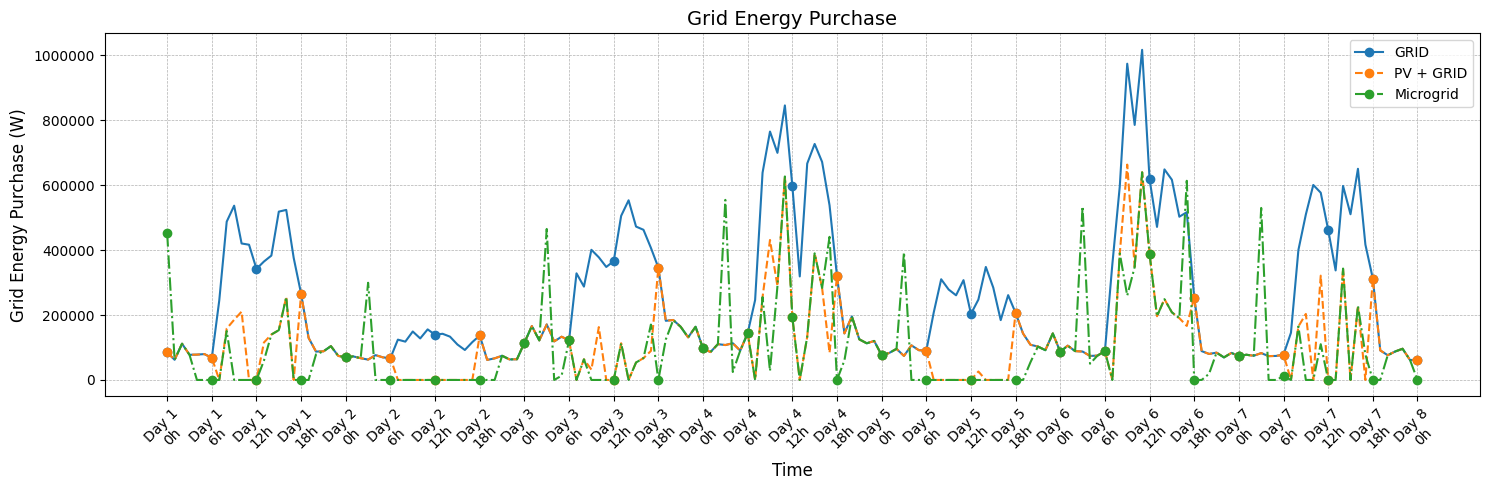

In [ ]:
from matplotlib.ticker import FuncFormatter, MultipleLocator

def format_yaxis(value, _):
    return f'{int(value)}'  # Hiện số đầy đủ, không dấu phẩy

sample_interval = 1  # Giữ nguyên lấy mẫu mỗi giờ
plot_interval = 6    # Mỗi 6 giờ vẽ 1 marker, label và grid

# Dữ liệu đầu vào
grid_use_only_vals = [safe_val(P_grid_use_only[t]) for t in hours]
grid_use_pv_vals = [safe_val(P_grid_use_pv[t]) for t in hours]
grid_use_micro_vals = [safe_val(P_grid_use_demand[t]) + safe_val(P_grid_charge[t]) for t in hours]

# Lấy mẫu đầy đủ (vẫn mỗi giờ, để giữ đủ dữ liệu vẽ)
sampled_hours = list(range(0, len(P_solar), sample_interval))
sampled_grid_use_only = [grid_use_only_vals[t] for t in sampled_hours]
sampled_grid_use_pv = [grid_use_pv_vals[t] for t in sampled_hours]
sampled_grid_use_micro = [grid_use_micro_vals[t] for t in sampled_hours]

# Tạo nhãn trục X
sampled_labels = []
for h in sampled_hours:
    day = h // 24 + 1
    hour_in_day = h % 24
    sampled_labels.append(f"Day {day}\n{hour_in_day}h")

# Tạo vị trí vẽ nhãn và grid mỗi 6 giờ
xtick_positions = sampled_hours[::plot_interval]
xtick_labels = [sampled_labels[i] for i in range(0, len(sampled_labels), plot_interval)]

# Vẽ biểu đồ
plt.figure(figsize=(15, 5))
plt.plot(sampled_hours, sampled_grid_use_only, label="GRID", linestyle='-', marker='o', markevery=plot_interval)
plt.plot(sampled_hours, sampled_grid_use_pv, label="PV + GRID", linestyle='--', marker='o', markevery=plot_interval)
plt.plot(sampled_hours, sampled_grid_use_micro, label="Microgrid", linestyle='-.', marker='o', markevery=plot_interval)

plt.title("Grid Energy Purchase", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Grid Energy Purchase (W)", fontsize=12)

# Gán nhãn và grid X mỗi 6 giờ
plt.xticks(xtick_positions, xtick_labels, rotation=45)
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Format trục Y không dấu phẩy, không dạng 1e6
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))

plt.legend()
plt.tight_layout()
plt.show()


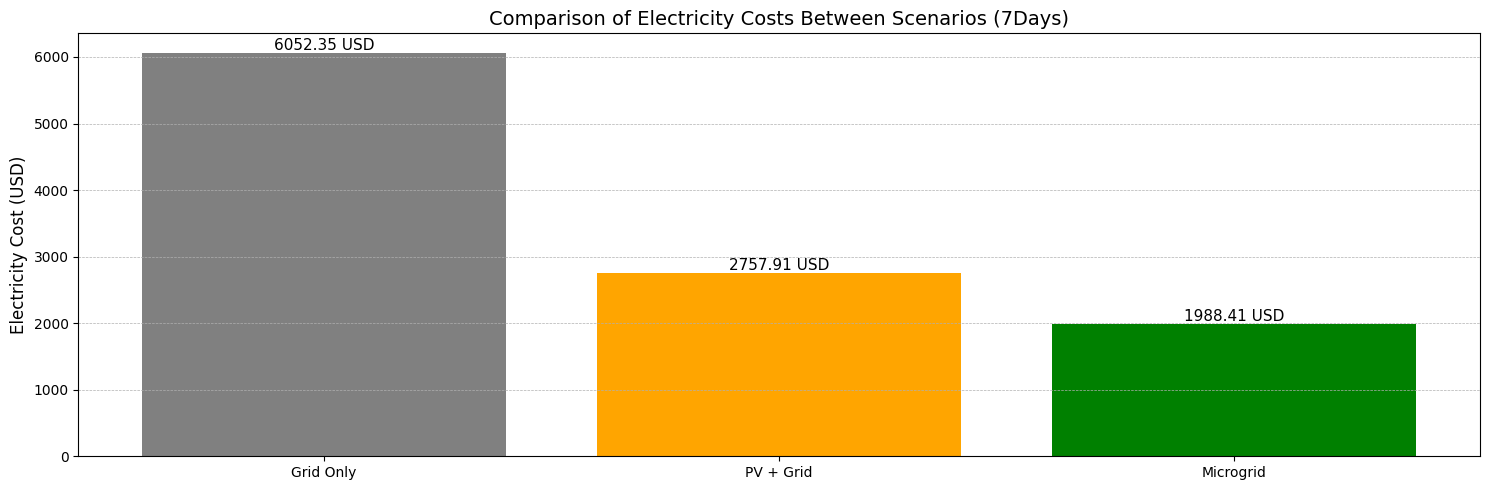

In [ ]:
import matplotlib.pyplot as plt

# Danh sách các kịch bản và chi phí tương ứng
scenarios = ["Grid Only", "PV + Grid", "Microgrid"]
costs = [cost_grid_only, cost_pv_grid, cost_microgrid]

# Vẽ biểu đồ cột
plt.figure(figsize=(15, 5))
bars = plt.bar(scenarios, costs, color=["gray", "orange", "green"])

# Hiển thị giá trị chi phí trên mỗi cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1,
             f"{height:.2f} USD", ha='center', va='bottom', fontsize=11)

# Cài đặt đồ thị
plt.title("Comparison of Electricity Costs Between Scenarios (7Days)", fontsize=14)
plt.ylabel("Electricity Cost (USD)", fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# 1. Tổng phụ tải (demand)
total_demand = np.sum(demand) / 1000  # kW

# 2. Tổng công suất mặt trời (P_solar)
total_p_solar = np.sum(P_solar) / 1000  # kW

# 3, 4, 5, 6 cho từng trường hợp

# Trường hợp 1: Microgrid (GRID + PV + BESS)
total_grid_use_microgrid = sum(safe_val(P_grid_use_demand[t]) for t in hours) / 1000
total_grid_charge_microgrid = sum(safe_val(P_grid_charge[t]) for t in hours) / 1000
total_solar_charge_microgrid = sum(safe_val(P_solar_charge[t]) for t in hours) / 1000
total_pv_to_load_microgrid = sum(safe_val(P_solar_use_demand[t]) for t in hours) / 1000
total_discharge_microgrid = sum(safe_val(P_discharge[t]) for t in hours) / 1000
total_cost_microgrid = cost_microgrid

# Trường hợp 2: Chỉ nối lưới (GRID ONLY)
total_grid_use_gridonly = sum(safe_val(P_grid_use_only[t]) for t in hours) / 1000
total_cost_gridonly = cost_grid_only

# Trường hợp 3: PV + nối lưới (GRID + PV, không BESS)
total_grid_use_pvgrid = sum(safe_val(P_grid_use_pv[t]) for t in hours) / 1000
total_pv_to_load_pvgrid = sum(min(P_solar[t], demand[t]) for t in hours) / 1000
total_cost_pvgrid = cost_pv_grid

# In kết quả
print("\n===== Tổng hợp kết quả =====")
print(f"Tổng phụ tải (demand): {total_demand:.1f} kW")
print(f"Tổng công suất mặt trời (P_solar): {total_p_solar:.1f} kW")

print("\n-- Trường hợp Microgrid (GRID+PV+BESS) --")
print(f"Tổng lượng điện mua từ lưới: {total_grid_use_microgrid + total_grid_charge_microgrid:.1f} kW")
print(f"Tổng lượng điện mặt trời dùng cho tải: {total_pv_to_load_microgrid:.1f} kW")
print(f"Tổng lượng pin đã được sạc: {total_grid_charge_microgrid + total_solar_charge_microgrid:.1f} kW")
print(f"Tổng lượng pin dùng cho tải : {total_discharge_microgrid:.1f} kW")
print(f"Tổng chi phí: {total_cost_microgrid:.2f} USD")

print("\n-- Trường hợp Chỉ nối lưới (GRID ONLY) --")
print(f"Tổng lượng điện mua từ lưới: {total_grid_use_gridonly:.1f} kW")
print(f"Tổng chi phí: {total_cost_gridonly:.2f} USD")

print("\n-- Trường hợp PV + nối lưới (GRID + PV, không BESS) --")
print(f"Tổng lượng điện mua từ lưới: {total_grid_use_pvgrid:.1f} kW")
print(f"Tổng lượng điện mặt trời dùng cho tải: {total_pv_to_load_pvgrid:.1f} kW")
print(f"Tổng chi phí: {total_cost_pvgrid:.2f} USD")


===== Tổng hợp kết quả =====
Tổng phụ tải (demand): 42628.6 kW
Tổng công suất mặt trời (P_solar): 29186.2 kW

-- Trường hợp Microgrid (GRID+PV+BESS) --
Tổng lượng điện mua từ lưới: 16949.2 kW
Tổng lượng điện mặt trời dùng cho tải: 22388.5 kW
Tổng lượng pin đã được sạc: 6520.6 kW
Tổng lượng pin dùng cho tải : 5947.6 kW
Tổng chi phí: 1988.41 USD

-- Trường hợp Chỉ nối lưới (GRID ONLY) --
Tổng lượng điện mua từ lưới: 42628.6 kW
Tổng chi phí: 6052.35 USD

-- Trường hợp PV + nối lưới (GRID + PV, không BESS) --
Tổng lượng điện mua từ lưới: 19373.1 kW
Tổng lượng điện mặt trời dùng cho tải: 23255.5 kW
Tổng chi phí: 2757.91 USD
